# **Reference**
Model: https://colab.research.google.com/drive/16GBgwYR2ECiXVxA1BoLxYshKczNMeEAQ?usp=sharing

Training Process: https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb

Other useful reference:

https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing

https://github.com/dzerkes/A-Representational-Similarity-Analysis-of-the-Dynamics-of-Object-Processing-Using-Single--Trial-EEG-/tree/master

# **Mount To Google Drive**
I'm not sure whether you can access the data in my google drive.

If not, please upload the .mat files to directory `ProjectDataset` in your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Packages**

In [ ]:
# for dataset
import scipy.io
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

# for model
import torch
import torch.nn as nn
from torch.nn import Linear, Module
import torch.nn.functional as F

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score

myseed = 3407  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Current device is '{device}'")
    return device

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your GNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training Steps')
    plt.ylabel('CrossEntropy Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

In [ ]:
# For save Training result and corresponding setting
class TrainingLog:
  def __init__(self):
    self.model_log = ''
    self.loss_log = ''
    self.accuracy_log = ''

  def update_model(self, model):
    print(model)
    print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
    self.model_log = str(model) + "\nNumber of parameters: " + str(sum(p.numel() for p in model.parameters())) + '\n'

  def update_loss(self, epoch, min_loss, accuracy):
    print(f'Saving model (epoch = {epoch+1:4d}, loss = {min_loss:.4f}, accuracy = {accuracy:.4%})')
    self.loss_log = f'Training Epoches = {epoch+1:4d}, Min_loss = {min_loss:.4f}\n'

  def update_accuracy(self, accuracy):
    print(f'Accuracy = {accuracy:.4%}')
    self.accuracy_log = f'Accuracy = {accuracy:.4%}\n'

  def save_result(self, data_config, config):
    # The format still needs to be modified...
    data_log = 'Dataset Setting:\n' + \
          f'Selected .mat file = {data_config["chosen_mat"]}\n' + \
          f'Preprocess: {data_config["pre_mode"]}\n' + \
          f'Edge_formulation: {data_config["edge_mode"]}\n'
    train_log = ''

    output = '===================\n' + \
          'Model:\n' + self.model_log + \
          '------------------\n' + \
          data_log + \
          '------------------\n' + \
          'Result:\n'+ \
          self.loss_log + \
          self.accuracy_log + \
          '===================\n\n'
    with open('log.txt', mode='a') as file:
      file.write(output)

training_log = TrainingLog()

# **Non-Neural Network**

## **Dataset**

In [ ]:
def NNN_dataset(chosen_mat):
  file_path = f'/content/drive/My Drive/ProjectDataset/S{chosen_mat}.mat'
  mat_file = scipy.io.loadmat(file_path) # load mat file

  X = mat_file['X_2D']
  y = mat_file['categoryLabels'].reshape((-1))
  return X, y

## **Split Dataset**

In [ ]:
def NNN_split(X, y, test_ratio, random_state):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
  return X_train, X_test, y_train, y_test

## **Average Test**

In [ ]:
def NNN_average_test(Classifier, hparas={}):
  accuracy_result = []
  for i in range(1, 11):
    X, y = NNN_dataset(i)
    X_train, X_test, y_train, y_test = NNN_split(X, y, 0.2, myseed)
    print(f'======================={i} iteration=======================')
    clf = Classifier(**hparas)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    correct = int((pred == y_test).sum())
    accuracy = correct / len(X_train)
    print(f'Accuracy = {accuracy:.4%}\n')
    accuracy_result.append(accuracy)

  print(f'===========================================')
  print(f'Average Accuracy: {np.mean(accuracy):.4%}')

## **Linear Discriminant Analysis**

In [ ]:
chosen_mat = 1
X, y = NNN_dataset(chosen_mat)
X_train, X_test, y_train, y_test = NNN_split(X, y, 0.2, myseed)
len(X_train), len(y_train), len(X_test), len(y_test)

(4150, 4150, 1038, 1038)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
correct = int((pred == y_test).sum())
accuracy = correct / len(X_train)
print(f'Accuracy = {accuracy:.4%}\n')

Accuracy = 5.6145%



In [ ]:
NNN_average_test(LinearDiscriminantAnalysis)

=======================1 iteration=======================
Accuracy = 5.6145%

=======================2 iteration=======================
Accuracy = 5.5689%

=======================3 iteration=======================
Accuracy = 5.7618%

=======================4 iteration=======================
Accuracy = 5.8582%

=======================5 iteration=======================
Accuracy = 6.5333%

=======================6 iteration=======================
Accuracy = 6.5815%

=======================7 iteration=======================
Accuracy = 6.1446%

=======================8 iteration=======================
Accuracy = 5.1604%

=======================9 iteration=======================
Accuracy = 5.9788%

=======================10 iteration=======================
Accuracy = 6.9207%

Average Accuracy: 6.9207%


## **Gaussian Naive Bayes Classifier**

In [ ]:
chosen_mat = 1
X, y = NNN_dataset(chosen_mat)
X_train, X_test, y_train, y_test = NNN_split(X, y, 0.2, myseed)
len(X_train), len(y_train), len(X_test), len(y_test)

(4150, 4150, 1038, 1038)

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
correct = int((pred == y_test).sum())
accuracy = correct / len(X_train)
print(f'Accuracy = {accuracy:.4%}\n')

Accuracy = 7.6145%



In [ ]:
NNN_average_test(GaussianNB)

=======================1 iteration=======================
Accuracy = 7.6145%

=======================2 iteration=======================
Accuracy = 7.5699%

=======================3 iteration=======================
Accuracy = 6.6779%

=======================4 iteration=======================
Accuracy = 4.5082%

=======================5 iteration=======================
Accuracy = 8.7512%

=======================6 iteration=======================
Accuracy = 8.6789%

=======================7 iteration=======================
Accuracy = 9.3735%

=======================8 iteration=======================
Accuracy = 5.5221%

=======================9 iteration=======================
Accuracy = 6.5815%

=======================10 iteration=======================
Accuracy = 8.1505%

Average Accuracy: 8.1505%


## **Random Forest**

In [ ]:
chosen_mat = 1
X, y = NNN_dataset(chosen_mat)
X_train, X_test, y_train, y_test = NNN_split(X, y, 0.2, myseed)
len(X_train), len(y_train), len(X_test), len(y_test)

(4150, 4150, 1038, 1038)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

hparas = {
    "n_estimators": 150,
    "criterion": "entropy",
}
clf = RandomForestClassifier(**hparas)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
correct = int((pred == y_test).sum())
accuracy = correct / len(X_train)
print(f'Accuracy = {accuracy:.4%}\n')

Accuracy = 8.4337%



In [ ]:
NNN_average_test(RandomForestClassifier, hparas)

=======================1 iteration=======================
Accuracy = 8.3133%

=======================2 iteration=======================
Accuracy = 7.3770%

=======================3 iteration=======================
Accuracy = 9.4021%

=======================4 iteration=======================
Accuracy = 8.0521%

=======================5 iteration=======================
Accuracy = 9.5468%

=======================6 iteration=======================
Accuracy = 10.7040%

=======================7 iteration=======================
Accuracy = 10.1205%

=======================8 iteration=======================
Accuracy = 7.0895%

=======================9 iteration=======================
Accuracy = 8.6307%

=======================10 iteration=======================
Accuracy = 9.2597%

Average Accuracy: 9.2597%


## **SVM with kernel 'rbf'**

In [ ]:
chosen_mat = 1
X, y = NNN_dataset(chosen_mat)
X_train, X_test, y_train, y_test = NNN_split(X, y, 0.2, myseed)
len(X_train), len(y_train), len(X_test), len(y_test)

(4150, 4150, 1038, 1038)

In [ ]:
from sklearn import svm

hparas = {
    "kernel": 'rbf',
    'decision_function_shape': 'ovo'
}
clf = svm.SVC(**hparas)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
correct = int((pred == y_test).sum())
accuracy = correct / len(X_train)
print(f'Accuracy = {accuracy:.4%}\n')

Accuracy = 9.8313%



In [ ]:
NNN_average_test(svm.SVC, hparas)

=======================1 iteration=======================
Accuracy = 9.8313%

=======================2 iteration=======================
Accuracy = 9.3057%

=======================3 iteration=======================
Accuracy = 10.5834%

=======================4 iteration=======================
Accuracy = 9.1369%

=======================5 iteration=======================
Accuracy = 11.4754%

=======================6 iteration=======================
Accuracy = 12.2710%

=======================7 iteration=======================
Accuracy = 11.5663%

=======================8 iteration=======================
Accuracy = 8.1987%

=======================9 iteration=======================
Accuracy = 10.2459%

=======================10 iteration=======================
Accuracy = 11.1406%

Average Accuracy: 11.1406%


# **Neural Network**

## **Dataset**

In [ ]:
class FNNDataset(Dataset):
    def __init__(self, idx, mode):

        # Read data into numpy arrays
        file_path = f'/content/drive/My Drive/ProjectDataset/S{idx}.mat'
        mat_file = scipy.io.loadmat(file_path) # load mat file

        # Training data (train/dev sets)
        target = (mat_file['categoryLabels'] - 1)[0, :]
        X = mat_file['X_2D']
        X -= np.mean(X, axis=0)
        pca = PCA(n_components=180)
        pca.fit(X)
        data = pca.transform(X)
        n = data.shape[0]

        permutation = np.random.permutation(n)
        data = data[permutation]
        # Splitting training data into train & dev & test sets
        if mode == 'train':
            indices = [i for i in range(n) if i % 10 > 2]
        elif mode == 'dev':
            indices = [i for i in range(n) if i % 10 < 2]
        elif mode == 'test':
            indices = [i for i in range(n) if i % 10 == 2]

        # Convert data into PyTorch tensors
        self.data = torch.tensor(data[indices, :], dtype=torch.float32)
        self.target = torch.tensor(target[indices], dtype=torch.int64)

        self.dim = tuple(self.data.shape[1:])

        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.dim))

    def __getitem__(self, index):
        return self.data[index, :], self.target[index]

    def __len__(self):
        return len(self.data)

In [ ]:
class CNNDataset(Dataset):
    def __init__(self, idx, mode):

        # Read data into numpy arrays
        file_path = f'/content/drive/My Drive/ProjectDataset/S{idx}.mat'
        mat_file = scipy.io.loadmat(file_path) # load mat file

        # Training data (train/dev sets)
        target = (mat_file['categoryLabels'] - 1)[0, :]
        X = mat_file['X_2D']
        X -= np.mean(X, axis=0)
        data = X.reshape((-1, 1, 124, 32))
        n = data.shape[0]

        permutation = np.random.permutation(n)
        data = data[permutation]
        # Splitting training data into train & dev & test sets
        if mode == 'train':
            indices = [i for i in range(n) if i % 10 > 2]
        elif mode == 'dev':
            indices = [i for i in range(n) if i % 10 < 2]
        elif mode == 'test':
            indices = [i for i in range(n) if i % 10 == 2]

        # Convert data into PyTorch tensors
        self.data = torch.tensor(data[indices, :, :, :], dtype=torch.float32)
        self.target = torch.tensor(target[indices], dtype=torch.int64)

        self.dim = tuple(self.data.shape[1:])

        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'
              .format(mode, self.data.shape[0], self.dim))

    def __getitem__(self, index):
        return self.data[index, :, :, :], self.target[index]

    def __len__(self):
        return len(self.data)

## **DataLoader**

In [ ]:
def prep_dataloader(_Dataset, idx, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = _Dataset(idx, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

## **Models**

### **Fully Connected Neural Network**

In [ ]:
class FNN(Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(180, 160),
            nn.ReLU(),
            nn.Linear(160, 140),
            nn.Tanh(),
            nn.Linear(140, 120),
            nn.Tanh(),
            nn.Linear(120, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )

        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.layers(x)
        return x

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

### **Convolutional Neural Network**

In [ ]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [1, 124, 32]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 16, 2),
            nn.ReLU(),
            nn.Conv2d(16, 16, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(6912, 32), # 6912 or 18432
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 6),
            nn.Softmax(dim=1)
        )

        #self.cnn_layers = nn.Sequential(
        #    nn.Conv2d(1, 32, 3, 1, 0),
        #    nn.ReLU(),
        #)
        #
        #self.fc_layers = nn.Sequential(
        #    nn.Linear(117120, 128),
        #    nn.ReLU(),
        #    nn.Dropout(0.15),
        #    nn.Linear(128, 6)
        #)

        self.criterion = torch.nn.CrossEntropyLoss()


    def forward(self, x):
        # input (x): [batch_size, 1, 124, 32]
        # output: [batch_size, 6]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)
        # print(x.shape)
        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

## **Hyper-parameters**

The hyper-parameters for dataset and training process.

In [ ]:
device = get_device() # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

data_config = {
    'idx': 1, # S{idx}.mat
    'exemplar_level': False,
    'val_ratio': 0.1,
    'test_ratio': 0.1
}

config = {
    'n_epochs': 50,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.004,                 # learning rate of Adam
        'weight_decay': 0,           # for L2 regularization
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

Current device is 'cuda'


## **Train/Val/Test**

### **Train**

In [ ]:
def train(train_loader, val_loader, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_loss = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in train_loader:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
            out = model(x) # forward pass (compute output)
            loss = model.cal_loss(out, y)
            loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_loss, accuracy = dev(val_loader, model, device)
        if dev_loss < min_loss or True:
            # Save model if your model improved
            min_loss = dev_loss
            training_log.update_loss(epoch, min_loss, accuracy)
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1

        loss_record['dev'].append(dev_loss)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return loss_record

### **Validation**

In [ ]:
def dev(val_loader, model, device):
    ''' Calculate loss and accuracy of model on validation set'''
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    correct = 0
    for x, y in val_loader:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)      # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            out = model(x) # forward pass (compute output)
            loss = model.cal_loss(out, y)  # compute loss
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == y).sum())  # Check against ground-truth labels
        total_loss += loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(val_loader.dataset)       # compute averaged loss
    accuracy = correct / len(test_loader.dataset)  # Derive ratio of correct predictions.
    return total_loss, accuracy

### **Test**

In [ ]:
def test(test_loader, model, device):
    ''' Calculate accuracy of model on test set'''
    model.eval()

    y_pred = []
    y_true = []

    correct = 0
    for x, y in test_loader:  # Iterate in batches over the training/test dataset.
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == y).sum())  # Check against ground-truth labels.

        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())

    accuracy = correct / len(test_loader.dataset) # Derive ratio of correct predictions.
    training_log.update_accuracy(accuracy)

    f1_micro = f1_score(y_true, y_pred, average=None)
    print(f'f1_micro score for each class: {f1_micro}')
    print(f'f1_micro score average: {np.mean(np.array(f1_micro)):.2f}')

    return accuracy

### **Average Test**

In [ ]:
def average_test(_Dataset, Model, hparas, data_config, config, device, myseed):
  accuracy_result = []
  for idx in range(1, 11):
    data_config['chosen_mat'] = [idx]

    print('\n=======================================================')
    print(f'{idx} iteration')

    # create model and move it to 'device'
    model = Model(**hparas)
    model = model.to(device)
    if idx == 1:
      training_log.update_model(model)

    # create data loader
    train_loader = prep_dataloader(_Dataset, data_config['idx'], 'train', config['batch_size']) # for training
    val_loader = prep_dataloader(_Dataset, data_config['idx'], 'dev', config['batch_size']) # for early stop
    test_loader = prep_dataloader(_Dataset, data_config['idx'], 'test', config['batch_size']) # for testing

    model_loss_record = train(train_loader, val_loader, model, config, device)

    plot_learning_curve(model_loss_record, title='DNN model')

    del model
    model = Model(**hparas).to(device)
    ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
    model.load_state_dict(ckpt)
    accuracy = test(test_loader, model, device)

    accuracy_result.append(accuracy)

  print(f'=======================================================')
  print(f'Final accuracy for each dataset: {accuracy_result}')
  print(f'Average accuracy: {np.mean(accuracy_result):.4%}')

## **Generate Result**

### **Load Data and Model**

#### **Load Data**

In [ ]:
# create data loader
_Dataset = CNNDataset
train_loader = prep_dataloader(_Dataset, data_config['idx'], 'train', config['batch_size']) # for training
val_loader = prep_dataloader(_Dataset, data_config['idx'], 'dev', config['batch_size']) # for early stop
test_loader = prep_dataloader(_Dataset, data_config['idx'], 'test', config['batch_size']) # for testing

Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))


#### **Initialize Model**

In [ ]:
# create model and move it to 'device'
# model = FNN()
model = CNN()

model = model.to(device)
training_log.update_model(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=6912, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, 

### **Training**

In [ ]:
model_loss_record = train(train_loader, val_loader, model, config, device)

Saving model (epoch =    1, loss = 1.7913, accuracy = 34.6821%)
Saving model (epoch =    2, loss = 1.8202, accuracy = 28.1310%)
Saving model (epoch =    3, loss = 1.8482, accuracy = 28.5164%)
Saving model (epoch =    4, loss = 1.8041, accuracy = 35.0674%)
Saving model (epoch =    5, loss = 1.8384, accuracy = 31.4066%)
Saving model (epoch =    6, loss = 1.8277, accuracy = 36.4162%)
Saving model (epoch =    7, loss = 1.8330, accuracy = 36.0308%)
Saving model (epoch =    8, loss = 1.8546, accuracy = 34.1040%)
Saving model (epoch =    9, loss = 1.8508, accuracy = 33.9114%)
Saving model (epoch =   10, loss = 1.8534, accuracy = 35.4528%)
Saving model (epoch =   11, loss = 1.8429, accuracy = 36.4162%)
Saving model (epoch =   12, loss = 1.8648, accuracy = 33.1407%)
Saving model (epoch =   13, loss = 1.8600, accuracy = 34.4894%)
Saving model (epoch =   14, loss = 1.8559, accuracy = 35.6455%)
Saving model (epoch =   15, loss = 1.8627, accuracy = 32.5626%)
Saving model (epoch =   16, loss = 1.863

#### **Draw Learning Curve**

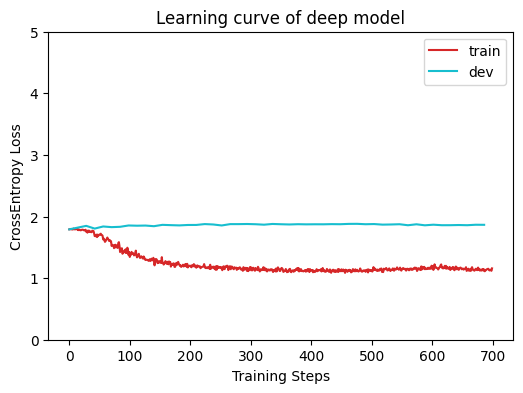

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

#### **Load Best Model and Test**
Please make sure the structure of the model is the same as that of the model you just trained

In [ ]:
del model
model = CNN().to(device) # same as the model you just trained
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
accuracy = test(test_loader, model, device)

Accuracy = 16.3776%
f1_micro score for each class: [0.2010582  0.15306122 0.15819209 0.20238095 0.15730337 0.09230769]
f1_micro score average: 0.16


### **Average Testing**


1 iteration
FNN(
  (layers): Sequential(
    (0): Linear(in_features=180, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=140, bias=True)
    (3): Tanh()
    (4): Linear(in_features=140, out_features=120, bias=True)
    (5): Tanh()
    (6): Linear(in_features=120, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=6, bias=True)
  )
  (criterion): CrossEntropyLoss()
)
Number of parameters:  78442
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7930, accuracy = 34.2967%)
Saving model (epoch =    2, loss = 1.8274, accuracy = 30.6358%)
Saving model (epoch =    3, loss = 1.8845, accuracy = 33.3333%)
Saving m

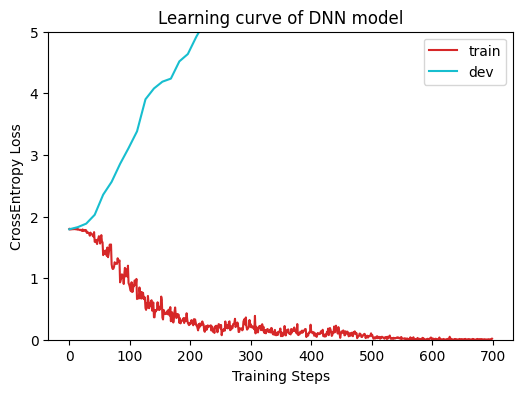

Accuracy = 15.0289%
f1_micro score for each class: [0.11560694 0.11398964 0.1954023  0.17777778 0.23030303 0.06535948]
f1_micro score average: 0.15

2 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7983, accuracy = 31.0212%)
Saving model (epoch =    2, loss = 1.8347, accuracy = 31.0212%)
Saving model (epoch =    3, loss = 1.8862, accuracy = 33.3333%)
Saving model (epoch =    4, loss = 2.0179, accuracy = 36.2235%)
Saving model (epoch =    5, loss = 2.3642, accuracy = 32.9480%)
Saving model (epoch =    6, loss = 2.5996, accuracy = 33.5260%)
Saving model (epoch =    7, loss = 2.9166, accuracy = 34.8748%)
Saving model (epoch =    8, loss = 3.1263, accuracy = 36.8015%)
Saving model (epoch =    9, loss = 3.3705, accuracy = 34.4894%)
Saving model (epoch =

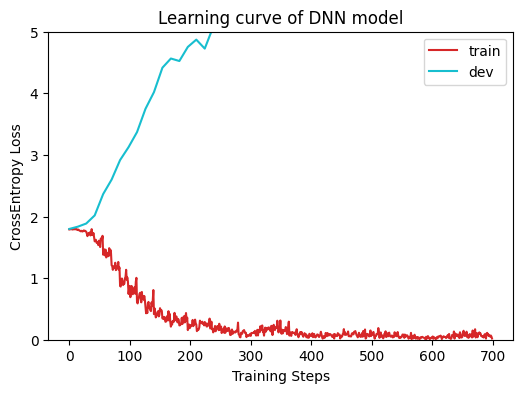

Accuracy = 16.5703%
f1_micro score for each class: [0.20833333 0.11904762 0.17       0.19736842 0.1656051  0.13017751]
f1_micro score average: 0.17

3 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7963, accuracy = 34.2967%)
Saving model (epoch =    2, loss = 1.8299, accuracy = 33.9114%)
Saving model (epoch =    3, loss = 1.8811, accuracy = 36.9942%)
Saving model (epoch =    4, loss = 2.0851, accuracy = 36.0308%)
Saving model (epoch =    5, loss = 2.3027, accuracy = 32.7553%)
Saving model (epoch =    6, loss = 2.5655, accuracy = 33.3333%)
Saving model (epoch =    7, loss = 2.9571, accuracy = 31.9846%)
Saving model (epoch =    8, loss = 3.2399, accuracy = 30.8285%)
Saving model (epoch =    9, loss = 3.5944, accuracy = 31.5992%)
Saving model (epoch =

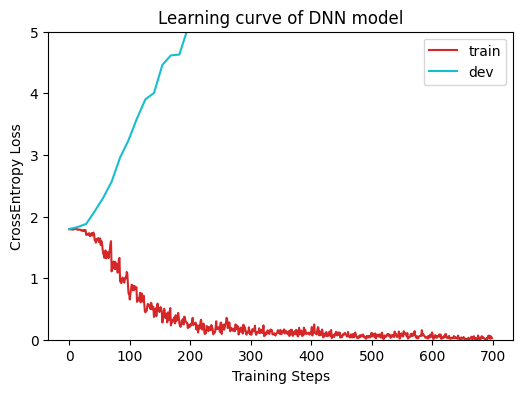

Accuracy = 13.6802%
f1_micro score for each class: [0.12290503 0.1878453  0.14141414 0.11363636 0.09655172 0.1509434 ]
f1_micro score average: 0.14

4 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7935, accuracy = 37.9576%)
Saving model (epoch =    2, loss = 1.8534, accuracy = 31.4066%)
Saving model (epoch =    3, loss = 1.9094, accuracy = 32.5626%)
Saving model (epoch =    4, loss = 2.0204, accuracy = 35.0674%)
Saving model (epoch =    5, loss = 2.3432, accuracy = 33.5260%)
Saving model (epoch =    6, loss = 2.6881, accuracy = 35.8382%)
Saving model (epoch =    7, loss = 2.9137, accuracy = 36.8015%)
Saving model (epoch =    8, loss = 3.0926, accuracy = 33.9114%)
Saving model (epoch =    9, loss = 3.5197, accuracy = 35.8382%)
Saving model (epoch =

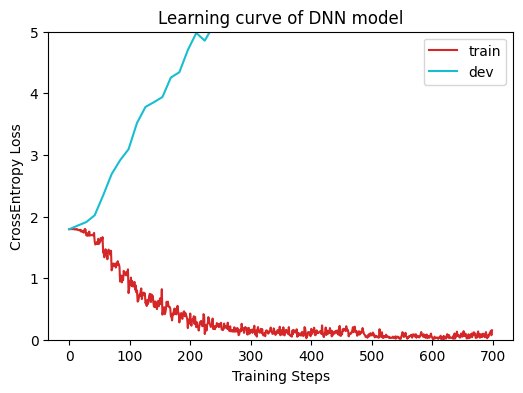

Accuracy = 15.9923%
f1_micro score for each class: [0.21875    0.16129032 0.16483516 0.07792208 0.14666667 0.17241379]
f1_micro score average: 0.16

5 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7924, accuracy = 33.9114%)
Saving model (epoch =    2, loss = 1.8088, accuracy = 30.2505%)
Saving model (epoch =    3, loss = 1.8879, accuracy = 32.9480%)
Saving model (epoch =    4, loss = 2.0556, accuracy = 32.5626%)
Saving model (epoch =    5, loss = 2.3668, accuracy = 31.7919%)
Saving model (epoch =    6, loss = 2.6623, accuracy = 31.7919%)
Saving model (epoch =    7, loss = 3.0478, accuracy = 34.6821%)
Saving model (epoch =    8, loss = 3.1733, accuracy = 31.9846%)
Saving model (epoch =    9, loss = 3.5634, accuracy = 33.5260%)
Saving model (epoch =

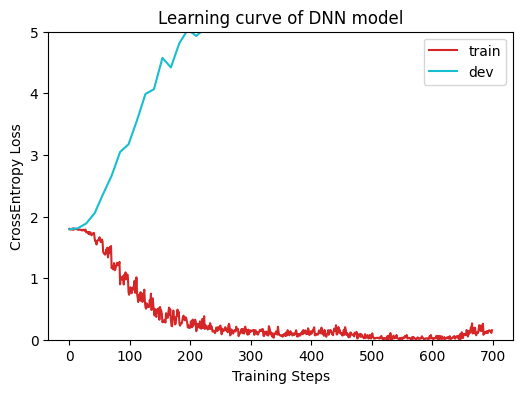

Accuracy = 17.3410%
f1_micro score for each class: [0.15584416 0.16304348 0.26470588 0.16352201 0.15568862 0.11764706]
f1_micro score average: 0.17

6 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7927, accuracy = 35.0674%)
Saving model (epoch =    2, loss = 1.8499, accuracy = 32.9480%)
Saving model (epoch =    3, loss = 1.9051, accuracy = 39.1137%)
Saving model (epoch =    4, loss = 2.0512, accuracy = 35.4528%)
Saving model (epoch =    5, loss = 2.3331, accuracy = 34.2967%)
Saving model (epoch =    6, loss = 2.6487, accuracy = 32.1773%)
Saving model (epoch =    7, loss = 2.9883, accuracy = 34.2967%)
Saving model (epoch =    8, loss = 3.2931, accuracy = 35.4528%)
Saving model (epoch =    9, loss = 3.5680, accuracy = 33.5260%)
Saving model (epoch =

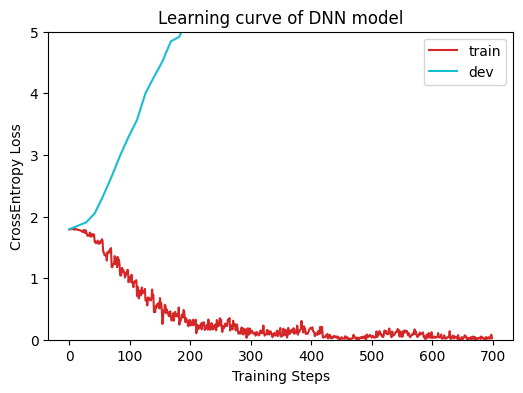

Accuracy = 18.3044%
f1_micro score for each class: [0.17801047 0.19631902 0.21505376 0.19277108 0.1038961  0.20224719]
f1_micro score average: 0.18

7 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7927, accuracy = 32.1773%)
Saving model (epoch =    2, loss = 1.8313, accuracy = 34.2967%)
Saving model (epoch =    3, loss = 1.9314, accuracy = 31.5992%)
Saving model (epoch =    4, loss = 2.1277, accuracy = 32.7553%)
Saving model (epoch =    5, loss = 2.4019, accuracy = 34.4894%)
Saving model (epoch =    6, loss = 2.6596, accuracy = 36.0308%)
Saving model (epoch =    7, loss = 3.0958, accuracy = 32.3699%)
Saving model (epoch =    8, loss = 3.2668, accuracy = 36.6089%)
Saving model (epoch =    9, loss = 3.4934, accuracy = 33.7187%)
Saving model (epoch =

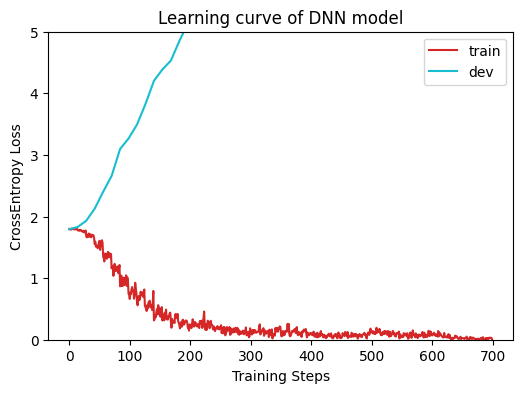

Accuracy = 16.5703%
f1_micro score for each class: [0.18947368 0.16766467 0.15853659 0.17751479 0.12429379 0.1754386 ]
f1_micro score average: 0.17

8 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7941, accuracy = 31.2139%)
Saving model (epoch =    2, loss = 1.8105, accuracy = 34.4894%)
Saving model (epoch =    3, loss = 1.8840, accuracy = 33.3333%)
Saving model (epoch =    4, loss = 1.9756, accuracy = 31.0212%)
Saving model (epoch =    5, loss = 2.3368, accuracy = 33.7187%)
Saving model (epoch =    6, loss = 2.4876, accuracy = 32.3699%)
Saving model (epoch =    7, loss = 2.7862, accuracy = 34.8748%)
Saving model (epoch =    8, loss = 3.1422, accuracy = 32.1773%)
Saving model (epoch =    9, loss = 3.2801, accuracy = 31.4066%)
Saving model (epoch =

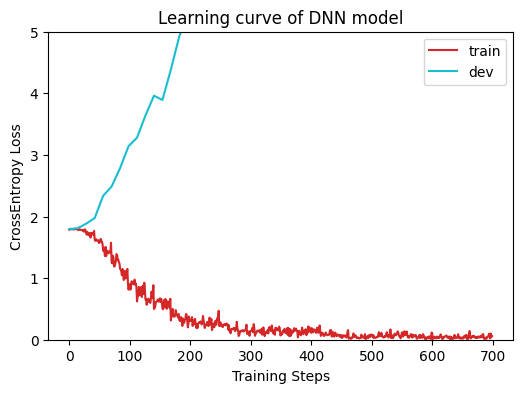

Accuracy = 16.1850%
f1_micro score for each class: [0.19672131 0.15841584 0.15544041 0.16470588 0.12987013 0.16176471]
f1_micro score average: 0.16

9 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.7978, accuracy = 33.3333%)
Saving model (epoch =    2, loss = 1.8447, accuracy = 36.6089%)
Saving model (epoch =    3, loss = 1.8721, accuracy = 35.0674%)
Saving model (epoch =    4, loss = 2.0290, accuracy = 36.8015%)
Saving model (epoch =    5, loss = 2.1713, accuracy = 36.0308%)
Saving model (epoch =    6, loss = 2.5784, accuracy = 35.2601%)
Saving model (epoch =    7, loss = 2.8540, accuracy = 32.1773%)
Saving model (epoch =    8, loss = 3.1001, accuracy = 34.1040%)
Saving model (epoch =    9, loss = 3.5631, accuracy = 31.5992%)
Saving model (epoch =

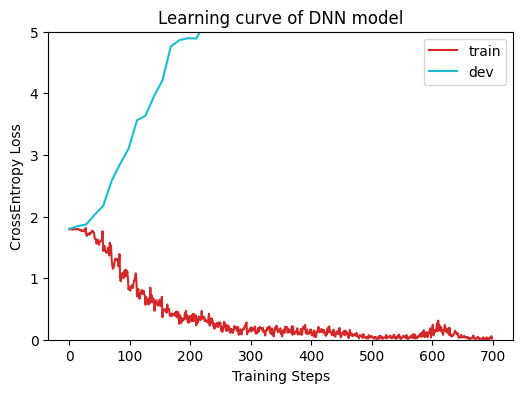

Accuracy = 18.4971%
f1_micro score for each class: [0.21989529 0.1865285  0.17021277 0.24309392 0.11842105 0.15037594]
f1_micro score average: 0.18

10 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (180,))
Finished reading the dev set of Dataset (1038 samples found, each dim = (180,))
Finished reading the test set of Dataset (519 samples found, each dim = (180,))
Saving model (epoch =    1, loss = 1.8020, accuracy = 31.4066%)
Saving model (epoch =    2, loss = 1.8462, accuracy = 31.0212%)
Saving model (epoch =    3, loss = 1.9534, accuracy = 30.8285%)
Saving model (epoch =    4, loss = 2.1451, accuracy = 31.0212%)
Saving model (epoch =    5, loss = 2.4196, accuracy = 35.2601%)
Saving model (epoch =    6, loss = 2.7872, accuracy = 32.3699%)
Saving model (epoch =    7, loss = 3.0648, accuracy = 32.5626%)
Saving model (epoch =    8, loss = 3.4399, accuracy = 29.4798%)
Saving model (epoch =    9, loss = 3.9250, accuracy = 32.5626%)
Saving model (epoch 

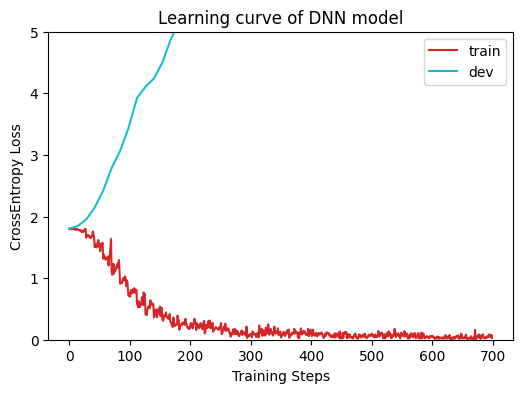

Accuracy = 19.4605%
f1_micro score for each class: [0.1547619  0.28       0.16042781 0.14285714 0.18064516 0.22988506]
f1_micro score average: 0.19
Final accuracy for each dataset: [0.15028901734104047, 0.16570327552986513, 0.13680154142581888, 0.1599229287090559, 0.17341040462427745, 0.18304431599229287, 0.16570327552986513, 0.16184971098265896, 0.18497109826589594, 0.19460500963391136]
Average accuracy: 16.7630%


In [ ]:
_Dataset = FNNDataset
Model = FNN
hparas = {}
average_test(_Dataset, Model, hparas, data_config, config, device, myseed)


1 iteration
CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=6912, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_

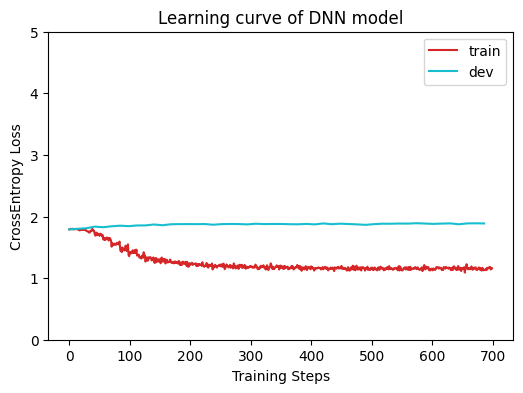

Accuracy = 15.2216%
f1_micro score for each class: [0.12765957 0.15135135 0.1452514  0.16352201 0.25806452 0.08139535]
f1_micro score average: 0.15

2 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7961, accuracy = 27.9383%)
Saving model (epoch =    2, loss = 1.7937, accuracy = 32.7553%)
Saving model (epoch =    3, loss = 1.8084, accuracy = 34.4894%)
Saving model (epoch =    4, loss = 1.8428, accuracy = 30.4432%)
Saving model (epoch =    5, loss = 1.8408, accuracy = 32.5626%)
Saving model (epoch =    6, loss = 1.8220, accuracy = 38.3430%)
Saving model (epoch =    7, loss = 1.8362, accuracy = 34.6821%)
Saving model (epoch =    8, loss = 1.8476, accuracy = 34.8748%)
Saving model (epoch =    9, loss = 1.8561, accuracy = 33.7187%)
Sav

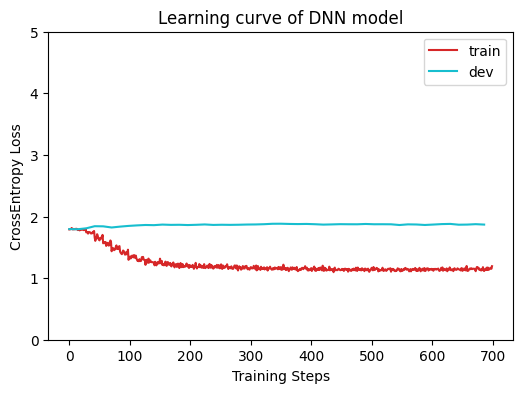

Accuracy = 18.1118%
f1_micro score for each class: [0.16216216 0.17777778 0.17142857 0.1595092  0.19277108 0.22485207]
f1_micro score average: 0.18

3 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7944, accuracy = 32.3699%)
Saving model (epoch =    2, loss = 1.8283, accuracy = 28.1310%)
Saving model (epoch =    3, loss = 1.8031, accuracy = 32.9480%)
Saving model (epoch =    4, loss = 1.8335, accuracy = 32.1773%)
Saving model (epoch =    5, loss = 1.8539, accuracy = 30.2505%)
Saving model (epoch =    6, loss = 1.8455, accuracy = 34.4894%)
Saving model (epoch =    7, loss = 1.8573, accuracy = 33.3333%)
Saving model (epoch =    8, loss = 1.8583, accuracy = 33.7187%)
Saving model (epoch =    9, loss = 1.8614, accuracy = 33.3333%)
Sav

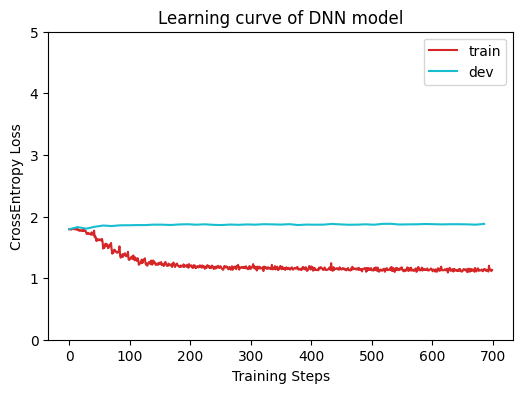

Accuracy = 16.9557%
f1_micro score for each class: [0.20618557 0.17989418 0.16774194 0.19459459 0.12345679 0.13071895]
f1_micro score average: 0.17

4 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7951, accuracy = 32.5626%)
Saving model (epoch =    2, loss = 1.8132, accuracy = 36.2235%)
Saving model (epoch =    3, loss = 1.7998, accuracy = 34.4894%)
Saving model (epoch =    4, loss = 1.8335, accuracy = 29.2871%)
Saving model (epoch =    5, loss = 1.8594, accuracy = 30.0578%)
Saving model (epoch =    6, loss = 1.8529, accuracy = 30.4432%)
Saving model (epoch =    7, loss = 1.8310, accuracy = 36.6089%)
Saving model (epoch =    8, loss = 1.8563, accuracy = 32.9480%)
Saving model (epoch =    9, loss = 1.8532, accuracy = 32.7553%)
Sav

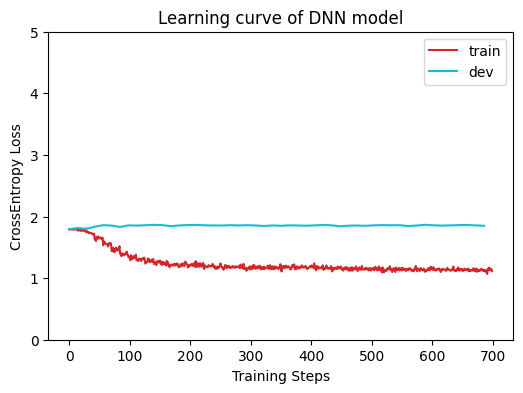

Accuracy = 16.1850%
f1_micro score for each class: [0.13483146 0.16080402 0.16304348 0.17721519 0.17283951 0.1656051 ]
f1_micro score average: 0.16

5 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7964, accuracy = 31.2139%)
Saving model (epoch =    2, loss = 1.8072, accuracy = 31.2139%)
Saving model (epoch =    3, loss = 1.8209, accuracy = 34.2967%)
Saving model (epoch =    4, loss = 1.8316, accuracy = 33.9114%)
Saving model (epoch =    5, loss = 1.8354, accuracy = 35.0674%)
Saving model (epoch =    6, loss = 1.8505, accuracy = 32.9480%)
Saving model (epoch =    7, loss = 1.8510, accuracy = 35.2601%)
Saving model (epoch =    8, loss = 1.8664, accuracy = 32.1773%)
Saving model (epoch =    9, loss = 1.8560, accuracy = 34.2967%)
Sav

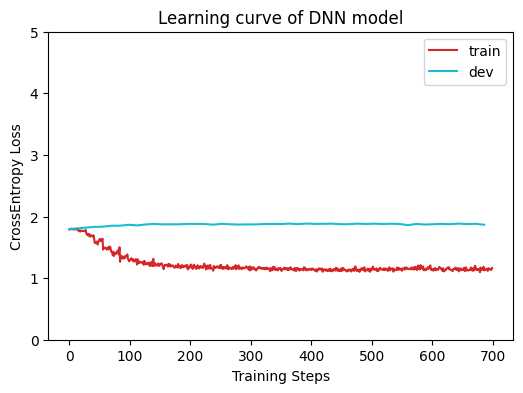

Accuracy = 15.6069%
f1_micro score for each class: [0.22330097 0.11392405 0.1627907  0.11042945 0.15384615 0.15286624]
f1_micro score average: 0.15

6 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7967, accuracy = 35.2601%)
Saving model (epoch =    2, loss = 1.8024, accuracy = 35.4528%)
Saving model (epoch =    3, loss = 1.8504, accuracy = 35.0674%)
Saving model (epoch =    4, loss = 1.8219, accuracy = 32.1773%)
Saving model (epoch =    5, loss = 1.8489, accuracy = 29.4798%)
Saving model (epoch =    6, loss = 1.8386, accuracy = 34.1040%)
Saving model (epoch =    7, loss = 1.8665, accuracy = 28.5164%)
Saving model (epoch =    8, loss = 1.8560, accuracy = 32.3699%)
Saving model (epoch =    9, loss = 1.8360, accuracy = 36.9942%)
Sav

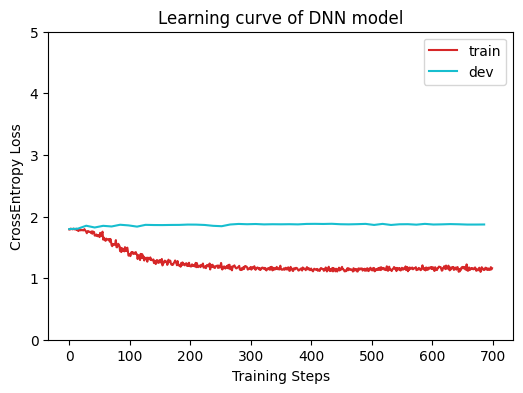

Accuracy = 14.8362%
f1_micro score for each class: [0.17346939 0.07185629 0.17857143 0.15204678 0.11392405 0.19101124]
f1_micro score average: 0.15

7 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7925, accuracy = 35.0674%)
Saving model (epoch =    2, loss = 1.7940, accuracy = 29.6724%)
Saving model (epoch =    3, loss = 1.8083, accuracy = 28.3237%)
Saving model (epoch =    4, loss = 1.8363, accuracy = 29.4798%)
Saving model (epoch =    5, loss = 1.8245, accuracy = 33.3333%)
Saving model (epoch =    6, loss = 1.8263, accuracy = 36.6089%)
Saving model (epoch =    7, loss = 1.8360, accuracy = 34.8748%)
Saving model (epoch =    8, loss = 1.8334, accuracy = 35.6455%)
Saving model (epoch =    9, loss = 1.8485, accuracy = 34.6821%)
Sav

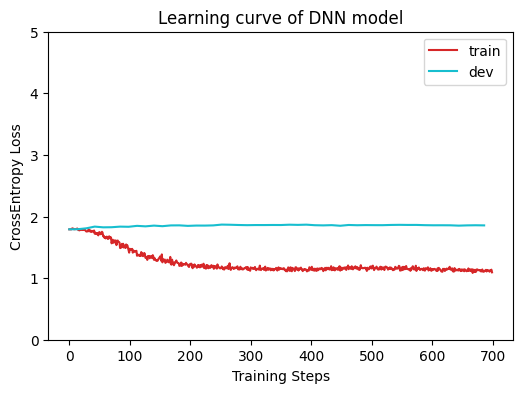

Accuracy = 15.9923%
f1_micro score for each class: [0.10526316 0.15555556 0.18090452 0.13580247 0.16049383 0.2195122 ]
f1_micro score average: 0.16

8 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7910, accuracy = 37.7649%)
Saving model (epoch =    2, loss = 1.8020, accuracy = 28.3237%)
Saving model (epoch =    3, loss = 1.8296, accuracy = 26.3969%)
Saving model (epoch =    4, loss = 1.8411, accuracy = 32.7553%)
Saving model (epoch =    5, loss = 1.8302, accuracy = 36.6089%)
Saving model (epoch =    6, loss = 1.8380, accuracy = 36.9942%)
Saving model (epoch =    7, loss = 1.8488, accuracy = 34.4894%)
Saving model (epoch =    8, loss = 1.8577, accuracy = 33.3333%)
Saving model (epoch =    9, loss = 1.8544, accuracy = 35.6455%)
Sav

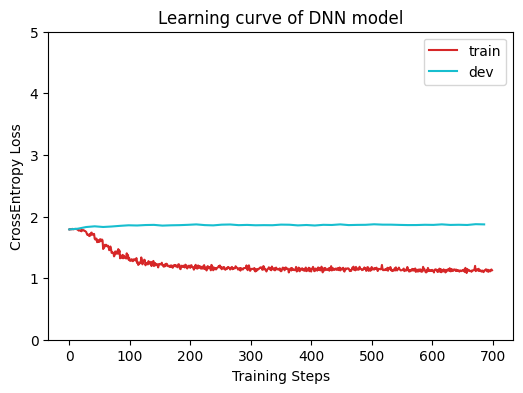

Accuracy = 17.1484%
f1_micro score for each class: [0.19895288 0.17857143 0.15625    0.15642458 0.21714286 0.10526316]
f1_micro score average: 0.17

9 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7936, accuracy = 32.3699%)
Saving model (epoch =    2, loss = 1.8047, accuracy = 28.3237%)
Saving model (epoch =    3, loss = 1.8014, accuracy = 36.8015%)
Saving model (epoch =    4, loss = 1.8361, accuracy = 30.4432%)
Saving model (epoch =    5, loss = 1.8477, accuracy = 33.3333%)
Saving model (epoch =    6, loss = 1.8450, accuracy = 34.1040%)
Saving model (epoch =    7, loss = 1.8290, accuracy = 38.3430%)
Saving model (epoch =    8, loss = 1.8562, accuracy = 33.3333%)
Saving model (epoch =    9, loss = 1.8462, accuracy = 35.8382%)
Sav

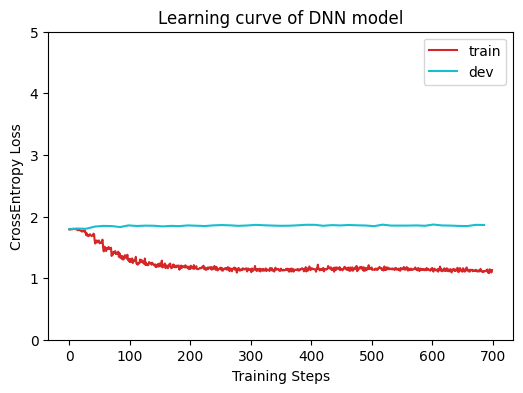

Accuracy = 18.4971%
f1_micro score for each class: [0.23333333 0.18627451 0.18994413 0.23684211 0.15757576 0.10126582]
f1_micro score average: 0.18

10 iteration
Finished reading the train set of Dataset (3631 samples found, each dim = (1, 124, 32))
Finished reading the dev set of Dataset (1038 samples found, each dim = (1, 124, 32))
Finished reading the test set of Dataset (519 samples found, each dim = (1, 124, 32))
Saving model (epoch =    1, loss = 1.7966, accuracy = 32.7553%)
Saving model (epoch =    2, loss = 1.7919, accuracy = 31.0212%)
Saving model (epoch =    3, loss = 1.8079, accuracy = 33.3333%)
Saving model (epoch =    4, loss = 1.8280, accuracy = 31.4066%)
Saving model (epoch =    5, loss = 1.8473, accuracy = 34.4894%)
Saving model (epoch =    6, loss = 1.8429, accuracy = 34.2967%)
Saving model (epoch =    7, loss = 1.8553, accuracy = 33.7187%)
Saving model (epoch =    8, loss = 1.8646, accuracy = 33.1407%)
Saving model (epoch =    9, loss = 1.8607, accuracy = 35.2601%)
Sa

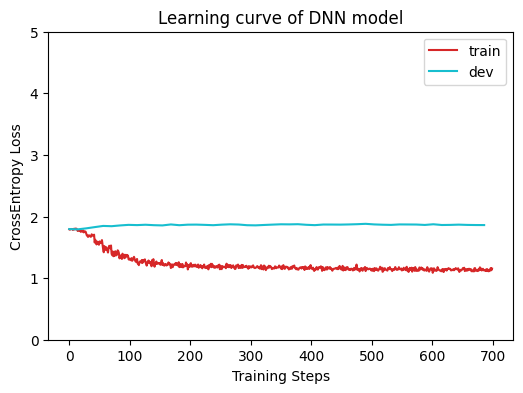

Accuracy = 15.6069%
f1_micro score for each class: [0.13872832 0.11428571 0.2408377  0.1954023  0.10588235 0.12903226]
f1_micro score average: 0.15
Final accuracy for each dataset: [0.15221579961464354, 0.1811175337186898, 0.16955684007707128, 0.16184971098265896, 0.15606936416184972, 0.14836223506743737, 0.1599229287090559, 0.17148362235067438, 0.18497109826589594, 0.15606936416184972]
Average accuracy: 16.4162%


In [ ]:
_Dataset = CNNDataset
Model = CNN
hparas = {}
average_test(_Dataset, Model, hparas, data_config, config, device, myseed)

### **Save Training Log**
Save the model structure, config and result, and append to the log.txt

In [ ]:
training_log.save_result(data_config, config)

# **Reference Codes**

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
from keras.callbacks import Callback
from scipy.io import loadmat
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
import itertools
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation
from keras.optimizers import Adam,Nadam
from numpy import linalg as la
from sklearn import preprocessing
from keras import regularizers
# from keras.backend.tensorflow_backend import set_session
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
import matplotlib.ticker as plticker

In [ ]:
# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [ ]:
def plot_cm(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm_cv1 = np.zeros((6,6))         # simple cnn
cm_cv2 = np.zeros((6,6))         # pca and simple cnn
cm_cv3 = np.zeros((6,6))         # pca, deep cnn
cm_cv4 = np.zeros((2,2))         # binary, pca, dfnn
cm_cv5 = np.zeros((2,2))         # binary, simple cnn
cm_cv6 = np.zeros((12,12))       # hf, exemplar, simple cnn
cm_cv7 = np.zeros((72,72))       # deep cnn

files = ["/content/drive/My Drive/ProjectDataset/S1.mat", "/content/drive/My Drive/ProjectDataset/S2.mat","/content/drive/My Drive/ProjectDataset/S3.mat","/content/drive/My Drive/ProjectDataset/S4.mat","/content/drive/My Drive/ProjectDataset/S5.mat","/content/drive/My Drive/ProjectDataset/S6.mat",
         "/content/drive/My Drive/ProjectDataset/S7.mat","/content/drive/My Drive/ProjectDataset/S8.mat","/content/drive/My Drive/ProjectDataset/S9.mat","/content/drive/My Drive/ProjectDataset/S10.mat"]
N = 32
electrodes = 124

## **PCA with Deep CNN**

In [ ]:
keep_accuracy = np.zeros((10))
j = 0

for participant in files:
    mat = loadmat(participant)
    X_2D = np.array(mat["X_2D"])
    categoryLabels = np.array(mat["categoryLabels"])     # get labels

    k = 180
    X = X_2D.copy()
    y = categoryLabels.ravel()
    X -= np.mean(X, axis=0)

    # [u,s,v] = la.svd(X)                                   # pca with svd, using an optimum k
    # v = v.transpose()
    # v_new = v[:,:k]
    # X_pca = np.dot(X, v_new)

    permutation = np.random.permutation(len(X))
    X = X[permutation]
    y = y[permutation]

    ratio = 0.7

    X_training = X[:int(ratio*len(X))]
    X_validation = X[int(ratio*len(X)):int(0.9*len(X))]
    X_test = X[int(0.9*len(X)):]

    y_training = y[:int(ratio*len(X))]
    y_validation = y[int(ratio*len(X)):int(0.9*len(X))]
    y_test = y[int(0.9*len(X)):]

    num_classes = 6
    y_training1hot = keras.utils.to_categorical(y_training - 1, num_classes) # We subtract 1 to convert to 0-index
    y_validation1hot = keras.utils.to_categorical(y_validation - 1, num_classes)
    y_test1hot = keras.utils.to_categorical(y_test - 1, num_classes)


    X_training = np.reshape(X_training, (-1, electrodes, N, 1))
    X_validation = np.reshape(X_validation, (-1, electrodes, N, 1))
    X_test = np.reshape(X_test, (-1, electrodes, N, 1))

    model = Sequential()

    model.add(Conv2D(8, kernel_size=3,input_shape=(124,32, 1), activation = 'relu'))
    model.add(Conv2D(8, kernel_size=3, activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(16, kernel_size=2,activation = 'relu'))
    model.add(Conv2D(16, kernel_size=2,activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(BatchNormalization())


    model.add(Conv2D(64, kernel_size=3, activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(6, activation = "softmax"))


    optimizer=Nadam(learning_rate=0.004)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


    model.fit(X_training, y_training1hot,                             # train the model
              epochs=50,
              validation_data=(X_validation, y_validation1hot),
              shuffle=True)

    y_validation_predictions = model.predict(X_validation, verbose=1)   # make predictions

    # create the confusion matrix
    cnf_matrix3 = confusion_matrix(y_validation-1, np.argmax(y_validation_predictions, axis=1))
    cm_cv3 += cnf_matrix3                                               # add together all the confusion matrices

    _, accuracy = model.evaluate(X_test, y_test1hot)        # find accuracy
    keep_accuracy[j] = accuracy
    j = j + 1
    print(" ")

print('Accuracy: %.2f' % (np.mean(keep_accuracy)*100))                  # print mean accuracy

# um_by_row = np.sum(cm_cv3, 1)                                          # normalize the final confusion matrix
# for i in range(0,6):
#    cm_cv3[i,:] = cm_cv3[i,:] / sum_by_row[i]

# plot_cm(np.round(cm_cv3, 4),6)

Epoch 1/50
114/114 [==============================] - 18s 16ms/step - loss: 1.8328 - accuracy: 0.1840 - val_loss: 1.9800 - val_accuracy: 0.1532
Epoch 2/50
114/114 [==============================] - 1s 11ms/step - loss: 1.7729 - accuracy: 0.2121 - val_loss: 2.4814 - val_accuracy: 0.1599
Epoch 3/50
114/114 [==============================] - 1s 10ms/step - loss: 1.7215 - accuracy: 0.2509 - val_loss: 2.5671 - val_accuracy: 0.2168
Epoch 4/50
114/114 [==============================] - 1s 10ms/step - loss: 1.6529 - accuracy: 0.2985 - val_loss: 2.7871 - val_accuracy: 0.1879
Epoch 5/50
114/114 [==============================] - 1s 11ms/step - loss: 1.5784 - accuracy: 0.3528 - val_loss: 1.7339 - val_accuracy: 0.2736
Epoch 6/50
114/114 [==============================] - 1s 11ms/step - loss: 1.4695 - accuracy: 0.4068 - val_loss: 1.7607 - val_accuracy: 0.3285
Epoch 7/50
114/114 [==============================] - 1s 10ms/step - loss: 1.3090 - accuracy: 0.4682 - val_loss: 1.7684 - val_accuracy: 0.330